# **Assignment 2: Advanced NLP**

**Author:** Orlando Closs  
**Date:** 6/03/2025

## Link to download Finetuned model trained in this notebook

https://github.com/orlandocloss/SRLClassification/releases/download/finetuned-model/BertSRLModel.zip

## Environment setup

Install required packages
```!pip install -r requirements.txt```

If you don't use the requirements.txt file, here are the main dependencies:
```!pip install pandas numpy tqdm evaluate transformers datasets matplotlib seaborn scikit-learn```

## Import packages

In [82]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from evaluate import load
import transformers
from datasets import Dataset, DatasetDict, ClassLabel, Features, Sequence, Value
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
import transformers
from transformers import DataCollatorForTokenClassification
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import numpy as np
from sklearn.metrics import classification_report

## Process and prepare raw data (from Assignment 1)

All steps in this section taken from Assignment 1.

In [2]:
class ConlluProcessor:

    def __init__(self, file_path): # initialize the class with the file path
        self.file_path = file_path # store the file path
        self.conllu_data = self.read_conllu_file() # read the conllu file and store the data

    def read_conllu_file(self): # define a method to read the conllu file
        """
        reads the conllu file and returns a list of sentences.
        """
        with open(self.file_path, 'r', encoding='utf-8') as file: # open the file with utf-8 encoding
            data = file.read() # read the file content
        return data.split('\n\n') # split the content into sentences

    def sentence_to_dataframe(self, sentence_conllu): # define a method to convert a sentence to a dataframe
        """
        converts a sentence in conllu format to a dataframe.
        """
        columns = ["ID", "WORD", "LEMMA", "POS-UNIV", "POS", "MORPH", "HEAD",  # define the column names
                   "BASIC-DEP", "ENHANCED-DEP", "MISC", "PREDICATE"] # continue defining column names
        rows = [] # initialize an empty list for rows
        sentence_text = '' # initialize an empty string for sentence text
        for row in sentence_conllu.split('\n'): # iterate over each row in the sentence
            if row and row[0].isdigit(): # check if the row is not empty and starts with a digit
                rows.append(row.split('\t')) # split the line by tab and add to rows
            elif row and row[2] == 't': # check if the row is not empty and the third character is 't'
                sentence_text = (row.split('= ')[1]) # extract the sentence text
                
        extra_columns = ["LABELS-P" + str(i+1) for i in range(len(rows[0]) - len(columns))] if rows else [] # create extra columns if needed

        df = pd.DataFrame(rows, columns=columns + extra_columns) # create a dataframe with the rows and columns

        if sentence_text != '': # check if sentence text is not empty
            return df, sentence_text # return the dataframe and sentence text
        else: # if sentence text is empty
            return None # return None

    def conllu_to_dataframes(self): # define a method to convert conllu data to dataframes
        """
        converts a list of sentences in conllu format to a dictionary of dataframes, where each dataframe contains the universal probbank data for a sentence.
        """
        dictionary = {} # initialize an empty dictionary
        for item in self.conllu_data: # iterate over each item in conllu data
            output = self.sentence_to_dataframe(item) # convert the item to a dataframe
            if output == None: # check if the output is None
                continue # skip to the next item
            else: # if output is not None
                dataframe, sentence_text = output # unpack the output
                dictionary[sentence_text] = dataframe # add the dataframe to the dictionary with sentence_text as the key
        return dictionary # return the dictionary

In [4]:
train_path = './en_ewt-up-train.conllu'
test_path = './en_ewt-up-test.conllu'
dev_path = './en_ewt-up-dev.conllu'

train_processor = ConlluProcessor(train_path)
test_processor = ConlluProcessor(test_path)
dev_processor = ConlluProcessor(dev_path)

train_dataframes = train_processor.conllu_to_dataframes()
test_dataframes = test_processor.conllu_to_dataframes()
dev_dataframes = dev_processor.conllu_to_dataframes()

In [5]:
def extract_predicates(df): 
    """
    Extracts predicates from a dataframe and returns a list of tuples, where each tuple contains the predicate string and dataframe (duplicate predicate labels).
    """

    output_dfs = []  # list to store output dataframes
    base_cols = list(df.loc[:, "ID":"MISC"].columns)  # columns to keep in the output
    for col in df.columns:
        if col in base_cols or col == "PREDICATE":  # skip base columns and PREDICATE column
            continue

        v_indices = df.index[df[col] == "V"].tolist()  # find indices where the column has 'V'
        for idx in v_indices:
            temp_df = df[base_cols + ["PREDICATE", col]].copy()  # create a temporary dataframe
            temp_df.rename(columns={col: "LABELS-P0"}, inplace=True)  # rename the column to LABELS-P0
            predicate_string = temp_df.loc[idx, "PREDICATE"]  # get the predicate string
            temp_df.loc[temp_df.index != idx, "PREDICATE"] = "_"  # set PREDICATE to '_' for non-matching indices
            temp_df = temp_df[base_cols + ["PREDICATE", "LABELS-P0"]]  # reorder columns
            output_dfs.append((predicate_string, temp_df))  # append the tuple to the output list
        
    return output_dfs  # return the list of tuples

def separate_label_predicates(dataframes):
    """
    Separates predicates from a dataframe and returns a dictionary of dataframes, where each key (sentence) starts with the predicate label.
    Completes the separation of predicates for all dataframes in the dictionary.
    """

    separated_dataframes = {}  # dictionary to store separated dataframes
    for sentence, df in dataframes.items():
        n_predicates = (df == 'V').sum().sum()  # count the number of predicates
        
        if n_predicates > 1:  # if more than one predicate
            output_dfs = extract_predicates(df)  # extract predicates
            for predicate_string, separated_df in output_dfs:
                separated_dataframes[predicate_string+"_"+sentence] = separated_df  # add to dictionary
        elif n_predicates == 0:  # no predicate we label it 0
            continue  # exclude 0 predicates
        else:  # exactly one predicate
            predicate_string = df.loc[df['PREDICATE'] != '_', 'PREDICATE'].values[0]  # get the predicate string
            separated_dataframes[predicate_string+"_"+sentence] = df  # add to dictionary
            df.rename(columns={"LABELS-P1": "LABELS-P0"}, inplace=True)  # rename column for consistency

    return separated_dataframes  # return the dictionary of separated dataframes

In [6]:
processed_test_dataframes=separate_label_predicates(test_dataframes)

processed_train_dataframes=separate_label_predicates(train_dataframes)

processed_dev_dataframes=separate_label_predicates(dev_dataframes)

In [15]:
print(f"Number of sentences in training data: {len(processed_train_dataframes)}")

print(f"Number of sentences in test data: {len(processed_test_dataframes)}")

print(f"Number of sentences in dev data: {len(processed_dev_dataframes)}")

train_total_tokens = sum(len(df) for df in processed_train_dataframes.values())
print(f"Total number of tokens in training data: {train_total_tokens}")

test_total_tokens = sum(len(df) for df in processed_test_dataframes.values())
print(f"Total number of tokens in test data: {test_total_tokens}")

dev_total_tokens = sum(len(df) for df in processed_dev_dataframes.values())
print(f"Total number of tokens in dev data: {dev_total_tokens}")

train_total_predicates = sum((df['PREDICATE'] != '_').sum() for df in processed_train_dataframes.values())
train_avg_predicates = train_total_predicates / len(processed_train_dataframes)
print(f"Average number of predicates per sentence in training data: {train_avg_predicates:.2f}")

test_total_predicates = sum((df['PREDICATE'] != '_').sum() for df in processed_test_dataframes.values())
test_avg_predicates = test_total_predicates / len(processed_test_dataframes)
print(f"Average number of predicates per sentence in test data: {test_avg_predicates:.2f}")

dev_total_predicates = sum((df['PREDICATE'] != '_').sum() for df in processed_dev_dataframes.values())
dev_avg_predicates = dev_total_predicates / len(processed_dev_dataframes)
print(f"Average number of predicates per sentence in dev data: {dev_avg_predicates:.2f}")

Number of sentences in training data: 37205
Number of sentences in test data: 4525
Number of sentences in dev data: 4705
Total number of tokens in training data: 931170
Total number of tokens in test data: 94434
Total number of tokens in dev data: 97909
Average number of predicates per sentence in training data: 1.00
Average number of predicates per sentence in test data: 1.00
Average number of predicates per sentence in dev data: 1.00


## Prepare datasets for BERT finetuning 

Same format as notebook token_classification.ipynb:

```
DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'predicate_pos', 'SRL_tags'],
        num_rows: x
    })
    validation: Dataset({
        features: ['id', 'tokens', 'predicate_pos', 'SRL_tags'],
        num_rows: x
    })
    test: Dataset({
        features: ['id', 'tokens', 'predicate_pos', 'SRL_tags'],
        num_rows: x
    })
 })
 ```

 Since we are following the token_classification.ipynb, we will use the same format for the datasets: including the features and the dictionary preparation.

In [23]:
#should find all labels in the train dataframes to define as ClassLabel "features"
all_labels = []  # initialize an empty list to store labels
for _, df in processed_train_dataframes.items():  # iterate over each dataframe in the processed train dataframes
    for tag in df['LABELS-P0'].unique():  # iterate over unique tags in the 'LABELS-P0' column
        if tag not in ['_', 'V', ''] and tag is not None and tag not in all_labels:  # check if tag is valid and not already in all_labels
            all_labels.append(tag)  # append the tag to all_labels

#make sure 'O' as first label
if 'O' not in all_labels:  # check if 'O' is not in all_labels
    all_labels = ['O'] + sorted(all_labels)  # add 'O' at the beginning and sort the rest
else:  # if 'O' is already in all_labels
    all_labels.remove('O')  # remove 'O' from its current position
    all_labels = ['O'] + sorted(all_labels)  # add 'O' at the beginning and sort the rest

#SRL_tags as ClassLabel as using train labels
features = Features({  # define features for train/validation datasets
    'id': Value('int32'),  # integer value for id
    'tokens': Sequence(Value('string')),  # sequence of strings for tokens
    'predicate_pos': Value('int32'),  # integer value for predicate position
    'SRL_tags': Sequence(ClassLabel(names=all_labels))  # sequence of class labels for SRL tags
})

def prepare_dictionary(dataframes, features):
    id=0
    list_of_dict=[]
    for sentence, df in tqdm(dataframes.items(), desc="Preparing dictionary for BERT"):
        tokens = []  # initialize empty list to store tokens of the current sentence
        SRL_tags=[]
        for index, row in df.iterrows(): 
            if row['LABELS-P0'] == '_' or row['LABELS-P0'] == 'V' or row['LABELS-P0'] == '':  # check the label in 'LABELS-P0' column
                SRL_tags.append('O')  # target label is 'O' if predicate or non argument
            else:
                SRL_tags.append(row['LABELS-P0'])  # append the actual label otherwise
            tokens.append(row['WORD'])  # append the word to the tokens list
        predicate_position = df[df['LABELS-P0'] == 'V'].index[0] 

        class_labels = features['SRL_tags'].feature
        processed_tags = []
        for tag in SRL_tags:
            try: # Try to get the index of the tag in the class labels
                processed_tags.append(class_labels.str2int(tag))
            except ValueError: # If tag is not in class labels, use 'O' (index 0) For unseen labels in test and dev
                processed_tags.append(0)
        SRL_tags = processed_tags

        dict_BERT={'id':id, 'tokens':tokens, 'predicate_pos':int(predicate_position),'SRL_tags':SRL_tags}
        list_of_dict.append(dict_BERT)
        id+=1
    return Dataset.from_list(list_of_dict, features=features)

In [24]:
train_dataset, dev_dataset, test_dataset = prepare_dictionary(processed_train_dataframes, features), prepare_dictionary(processed_dev_dataframes, features), prepare_dictionary(processed_test_dataframes, features)

datasets = DatasetDict({
    'train': train_dataset,
    'validation': dev_dataset,
    'test': test_dataset
})

Preparing dictionary for BERT:   0%|          | 0/37205 [00:00<?, ?it/s]

Preparing dictionary for BERT: 100%|██████████| 4525/4525 [00:02<00:00, 1621.11it/s]


## Inspect the datasets

Dataset should have the same format as token_classification.ipynb. All steps in this inspection taken from token_classification.ipynb.

In [25]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'predicate_pos', 'SRL_tags'],
        num_rows: 37205
    })
    validation: Dataset({
        features: ['id', 'tokens', 'predicate_pos', 'SRL_tags'],
        num_rows: 4705
    })
    test: Dataset({
        features: ['id', 'tokens', 'predicate_pos', 'SRL_tags'],
        num_rows: 4525
    })
})

In [26]:
datasets["train"][0]

{'id': 0,
 'tokens': ['Al',
  '-',
  'Zaman',
  ':',
  'American',
  'forces',
  'killed',
  'Shaikh',
  'Abdullah',
  'al',
  '-',
  'Ani',
  ',',
  'the',
  'preacher',
  'at',
  'the',
  'mosque',
  'in',
  'the',
  'town',
  'of',
  'Qaim',
  ',',
  'near',
  'the',
  'Syrian',
  'border',
  '.'],
 'predicate_pos': 6,
 'SRL_tags': [0,
  0,
  0,
  0,
  0,
  1,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  18,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

Check if ClassLabel features are correct

In [27]:
label_list = datasets["train"].features["SRL_tags"].feature.names
label_list

['O',
 'ARG0',
 'ARG1',
 'ARG1-DSP',
 'ARG2',
 'ARG3',
 'ARG4',
 'ARG5',
 'ARGA',
 'ARGM-ADJ',
 'ARGM-ADV',
 'ARGM-CAU',
 'ARGM-COM',
 'ARGM-CXN',
 'ARGM-DIR',
 'ARGM-DIS',
 'ARGM-EXT',
 'ARGM-GOL',
 'ARGM-LOC',
 'ARGM-LVB',
 'ARGM-MNR',
 'ARGM-MOD',
 'ARGM-NEG',
 'ARGM-PRD',
 'ARGM-PRP',
 'ARGM-PRR',
 'ARGM-REC',
 'ARGM-TMP',
 'C-ARG0',
 'C-ARG1',
 'C-ARG1-DSP',
 'C-ARG2',
 'C-ARG3',
 'C-ARG4',
 'C-ARGM-ADV',
 'C-ARGM-COM',
 'C-ARGM-CXN',
 'C-ARGM-DIR',
 'C-ARGM-EXT',
 'C-ARGM-GOL',
 'C-ARGM-LOC',
 'C-ARGM-MNR',
 'C-ARGM-PRP',
 'C-ARGM-PRR',
 'C-ARGM-TMP',
 'C-V',
 'R-ARG0',
 'R-ARG1',
 'R-ARG2',
 'R-ARG3',
 'R-ARG4',
 'R-ARGM-ADV',
 'R-ARGM-CAU',
 'R-ARGM-COM',
 'R-ARGM-DIR',
 'R-ARGM-GOL',
 'R-ARGM-LOC',
 'R-ARGM-MNR',
 'R-ARGM-TMP']

Display random elements (from token_classification.ipynb)

In [28]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [29]:
show_random_elements(datasets["train"])

,id,tokens,predicate_pos,SRL_tags
0,2299,"[Reports, from, Port, Blair, make, it, evident, that, New, Delhi, gets, little, on, -, the, -, ground, intelligence, ,, and, the, Indian, Coast, Guard, is, grossly, unequipped, to, deal, with, the, surge, of, illegal, migrants, to, the, islands, .]",0,"[O, O, O, ARG0, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,25887,"[True, or, false, :, being, a, young, New, Zealander, means, having, no, future, ?]",10,"[O, O, O, O, O, O, O, O, O, O, O, O, ARG1, O]"
2,16371,"[Dependant, =, NASA, &, Company, to, use, "", space, station, "", model, to, unify, the, aims, of, different, countries, .]",13,"[O, O, ARG0, O, O, O, O, O, O, O, O, O, O, O, O, ARG1, O, O, O, O]"
3,2452,"[Pakistani, officials, claim, there, are, as, many, as, 42, RAW, agents, based, in, Kandahar, and, another, 12, in, Jalalabad, .]",11,"[O, O, O, O, O, O, O, O, O, O, ARG1, O, O, ARGM-LOC, O, O, O, O, O, O]"
4,9677,"[Attached, is, the, letter, I, originally, sent, to, you, on, May, 10, in, this, regard, .]",6,"[O, O, O, ARG1, ARG0, ARGM-ADV, O, O, ARG2, O, ARGM-TMP, O, O, O, ARGM-ADV, O]"
5,11214,"[Peter, is, looking, currently, for, a, job, .]",1,"[O, O, O, O, O, O, O, O]"
6,27916,"[I, will, be, calling, my, vet, and, chiro, about, him, .]",2,"[O, O, O, O, O, O, O, O, O, O, O]"
7,9415,"[Attached, are, the, fax, cover, pages, for, each, of, the, Nylon, and, Polykron, Deemed, ISDAs, I, just, sent, you, .]",0,"[O, O, O, O, O, ARG1, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
8,37074,"[I, felt, very, much, like, Wedding, Gallery, was, being, dishonest, and, I, would, n't, trust, them, to, lace, me, up, in, another, gown, let, alone, trust, them, with, the, gown, I, will, wear, on, the, most, important, day, of, my, life, .]",9,"[O, O, O, O, O, O, ARG1, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
9,1879,"[Even, partition, is, not, a, possibility, ,, there, are, no, clear, borders, between, the, two, .]",2,"[O, ARG1, O, ARGM-NEG, O, ARG2, O, O, O, O, O, O, O, O, O, O]"


## Preprocessing the data (special token PRED)

We preprocess with the Transformer tokenizer putting it in a format the model expects (token_classification.ipynb). However, to refine for SRL classification, we add a special token [PRED] to the tokenizer. We are using the method from Peng Shi, Jimmy Lin (2019) (https://arxiv.org/abs/1904.05255); but instead of adding the predicate to the end of the sentence as a separate sentence, we just use the special token. This method was chosen due to a discussion in the lecture (Feb 24). The rest of the steps follow the token_classification.ipynb.

In [30]:
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

In [31]:
# source: https://huggingface.co/docs/transformers/main/main_classes/tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.add_special_tokens({'additional_special_tokens': ['[PRED]']}) #add special token to tokenizer

1

### Testing how to add special token to tokenizer before making alignment function.

We must add our special token to the tokens and then use the tokenizer to tokenize the modified tokens. We will tokenize the sentence before and after the predicate and then create our own word_ids to align the labels to the tokens with this special token. (this differs from token_classification.ipynb)

In [50]:
example = datasets["train"][7]  # get example from the training dataset
predicate_pos = example["predicate_pos"]

# since we are inserting PRED into the sentence, we must split the sentence into two parts
tokens_before = example["tokens"][:predicate_pos+1]
tokens_after = example["tokens"][predicate_pos+1:]

tokenized_before = tokenizer(tokens_before, is_split_into_words=True, add_special_tokens=False) #we dont want to add CLS and SEP yet as this should be done manually
tokenized_after = tokenizer(tokens_after, is_split_into_words=True, add_special_tokens=False)

#we can add PRED to the middle as made new special tokens
input_ids = [tokenizer.cls_token_id] + tokenized_before["input_ids"] + [tokenizer.additional_special_tokens_ids[0]] + tokenized_after["input_ids"] + [tokenizer.sep_token_id]

tokens=tokenizer.convert_ids_to_tokens(input_ids)

print(tokens)

['[CLS]', 'd', '##pa', ':', 'iraqi', 'authorities', 'announced', 'that', 'they', 'had', 'busted', '[PRED]', 'up', '3', 'terrorist', 'cells', 'operating', 'in', 'baghdad', '.', '[SEP]']


In [35]:
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast) #fast tokenizer (token_classification.ipynb)

Length is now not the same because of special tokens and could get split into subtokens through tokenizer. (token_classification.ipynb)

In [37]:
len(example["SRL_tags"]), len(input_ids)

(17, 21)

We align the new tokens to the word_ids (token_classification.ipynb). Here we can not use the tokenized_input.word_ids() and need to make our own word_ids for the special predicate token.

In [61]:
def make_word_ids(tokens_before, tokens_after, predicate_pos):
    word_ids = [None]  # CLS token

    for i, word in enumerate(tokens_before):
        num_subtokens = len(tokenizer(word, add_special_tokens=False)["input_ids"]) #apply tokenizer to one word to see how much it is split
        for _ in range(num_subtokens):
            word_ids.append(i)

    word_ids.append(None) #Pred token

    for i, word in enumerate(tokens_after):
        num_subtokens = len(tokenizer(word, add_special_tokens=False)["input_ids"])
        for _ in range(num_subtokens):
            word_ids.append(i + predicate_pos + 1)

    word_ids.append(None) #sep token
    return word_ids

word_ids=make_word_ids(tokens_before, tokens_after, predicate_pos)
word_ids

[None, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, None, 9, 10, 11, 12, 13, 14, 15, 16, None]

Now they should be the same length.

In [48]:
aligned_labels = [-100 if i is None else example["SRL_tags"][i] for i in word_ids]
print(len(aligned_labels), len(input_ids))

21 21


### Make alignment function

Make the process from above into one alignment function. This differs from token_classification.ipynb as we now must insert our [PRED] token to each sentence. 



In [62]:
label_all_tokens=True
def tokenize_and_align_labels(examples):

    #manually making tokenized inputs as must use tokenizer on splits
    tokenized_inputs = {"input_ids": [], "attention_mask": [], "labels": []} #this is output seen from using full tokenisations function (token_classification.ipynb)
    
    for i, tokens in enumerate(examples["tokens"]):
        predicate_pos = examples["predicate_pos"][i]
        tokens_before = tokens[:predicate_pos+1]
        tokens_after = tokens[predicate_pos+1:]

        tokenized_before = tokenizer(tokens_before, is_split_into_words=True, add_special_tokens=False)
        tokenized_after = tokenizer(tokens_after, is_split_into_words=True, add_special_tokens=False)

        input_ids = [tokenizer.cls_token_id] + tokenized_before["input_ids"] + [tokenizer.additional_special_tokens_ids[0]] + tokenized_after["input_ids"] + [tokenizer.sep_token_id]
        attention_mask = [1] * len(input_ids)
        
        tokenized_inputs["input_ids"].append(input_ids)
        tokenized_inputs["attention_mask"].append(attention_mask)

        label = examples["SRL_tags"][i]
        word_ids= make_word_ids(tokens_before, tokens_after, predicate_pos)
        previous_word_idx = None
        label_ids=[]
        
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        tokenized_inputs["labels"].append(label_ids)

    return tokenized_inputs

In [63]:
tokenize_and_align_labels(datasets['train'][:5])

{'input_ids': [[101,
   2632,
   1011,
   23564,
   2386,
   1024,
   2137,
   2749,
   2730,
   30522,
   21146,
   28209,
   14093,
   2632,
   1011,
   2019,
   2072,
   1010,
   1996,
   14512,
   2012,
   1996,
   8806,
   1999,
   1996,
   2237,
   1997,
   1053,
   4886,
   2213,
   1010,
   2379,
   1996,
   9042,
   3675,
   1012,
   102],
  [101,
   1031,
   2023,
   4288,
   30522,
   1997,
   1037,
   9768,
   29307,
   2097,
   2022,
   4786,
   2149,
   4390,
   2005,
   2086,
   2000,
   2272,
   1012,
   1033,
   102],
  [101,
   1031,
   2023,
   4288,
   1997,
   1037,
   9768,
   29307,
   2097,
   2022,
   30522,
   4786,
   2149,
   4390,
   2005,
   2086,
   2000,
   2272,
   1012,
   1033,
   102],
  [101,
   1031,
   2023,
   4288,
   1997,
   1037,
   9768,
   29307,
   2097,
   2022,
   4786,
   30522,
   2149,
   4390,
   2005,
   2086,
   2000,
   2272,
   1012,
   1033,
   102],
  [101,
   1031,
   2023,
   4288,
   1997,
   1037,
   9768,
   29307,
   2097

In [64]:
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/37205 [00:00<?, ? examples/s]

Map:   0%|          | 0/4705 [00:00<?, ? examples/s]

Map:   0%|          | 0/4525 [00:00<?, ? examples/s]

## Finetune the model

We use token classification model as token_classification.ipynb.

In [65]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list)) #same as token_classification.ipynb
model.resize_token_embeddings(len(tokenizer)) #must resize to suit special token


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(30523, 768, padding_idx=0)

Setup for training, all same as token_classification.ipynb.

In [68]:
model_name = model_checkpoint.split("/")[-1] #same as token_classification.ipynb
args = TrainingArguments(
    f"{model_name}-finetuned-SRL",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

data_collator = DataCollatorForTokenClassification(tokenizer) #same as token_classification.ipynb
metric = load("seqeval") #same as token_classification.ipynb, use load not load_metric
labels = [label_list[i] for i in example["SRL_tags"]] #same as token_classification.ipynb
metric.compute(predictions=[labels], references=[labels])

/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [72]:
def compute_metrics(p): #same as token_classification.ipynb
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [73]:
trainer = Trainer( #same as token_classification.ipynb
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_131676/1076666664.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer( #same as token_classification.ipynb


Train the model

In [74]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.123000,0.132300,0.739223,0.756536,0.747779,0.965025
2,0.083700,0.113823,0.792090,0.781046,0.786529,0.970521
3,0.069700,0.110550,0.792682,0.790523,0.791601,0.971455


/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARGM-TMP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: Use

TrainOutput(global_step=6978, training_loss=0.11864180003171938, metrics={'train_runtime': 546.7248, 'train_samples_per_second': 204.152, 'train_steps_per_second': 12.763, 'total_flos': 1941197839898856.0, 'train_loss': 0.11864180003171938, 'epoch': 3.0})

Evaluate

In [75]:
trainer.evaluate()

/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARGM-TMP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: Use

{'eval_loss': 0.11055047810077667,
 'eval_precision': 0.7926815947569634,
 'eval_recall': 0.7905228758169934,
 'eval_f1': 0.7916007635669483,
 'eval_accuracy': 0.9714552722158482,
 'eval_runtime': 4.7743,
 'eval_samples_per_second': 985.489,
 'eval_steps_per_second': 61.789,
 'epoch': 3.0}

Save the model

In [76]:
trainer.save_model("bert_srl_output")

## Get metrics (classification report and confusion matrix)

Must prepare predictions, labels and tokens for confusion matrix and classification report. 

For each test sentence, we map between BERT's subtokens and our original tokens using make_word_ids(). We create dictionaries that link original token positions to their predicted and gold labels, handling the subtoken splitting issue. Finally, we collect each token alongside its correct and predicted labels.

In [108]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"]) # from token_classification.ipynb
predictions = np.argmax(predictions, axis=2)

true_predictions = []
true_labels = []
true_tokens = []

for i in range(len(tokenized_datasets["test"])):
    example = tokenized_datasets["test"][i]
    pred = predictions[i]
    label = labels[i]
    
    original_tokens = example["tokens"] # get the original tokens for this example
    predicate_pos = example["predicate_pos"]
    
    #need to get word_ids for mapping subtoken positions back to original tokens
    tokens_before = original_tokens[:predicate_pos+1]
    tokens_after = original_tokens[predicate_pos+1:]
    word_ids = make_word_ids(tokens_before, tokens_after, predicate_pos)
    
    # create mapping from original token index to predicted label
    token_to_pred = {}
    token_to_gold = {}
    
    for j, (p, l, word_idx) in enumerate(zip(pred, label, word_ids)):
        if l != -100 and word_idx is not None:
            # only take the last subtoken prediction for each token
            token_to_pred[word_idx] = label_list[p]
            token_to_gold[word_idx] = label_list[l]
    
    # fill in predictions for each original token
    for j in range(len(original_tokens)):
        if j in token_to_pred:
            true_tokens.append(original_tokens[j])
            true_predictions.append(token_to_pred[j])
            true_labels.append(token_to_gold[j])

print(len(true_tokens), len(true_labels), len(true_predictions))

94434 94434 94434


Confusion matrix (taken from assignment 1 LogNorm as have heavy outliers)

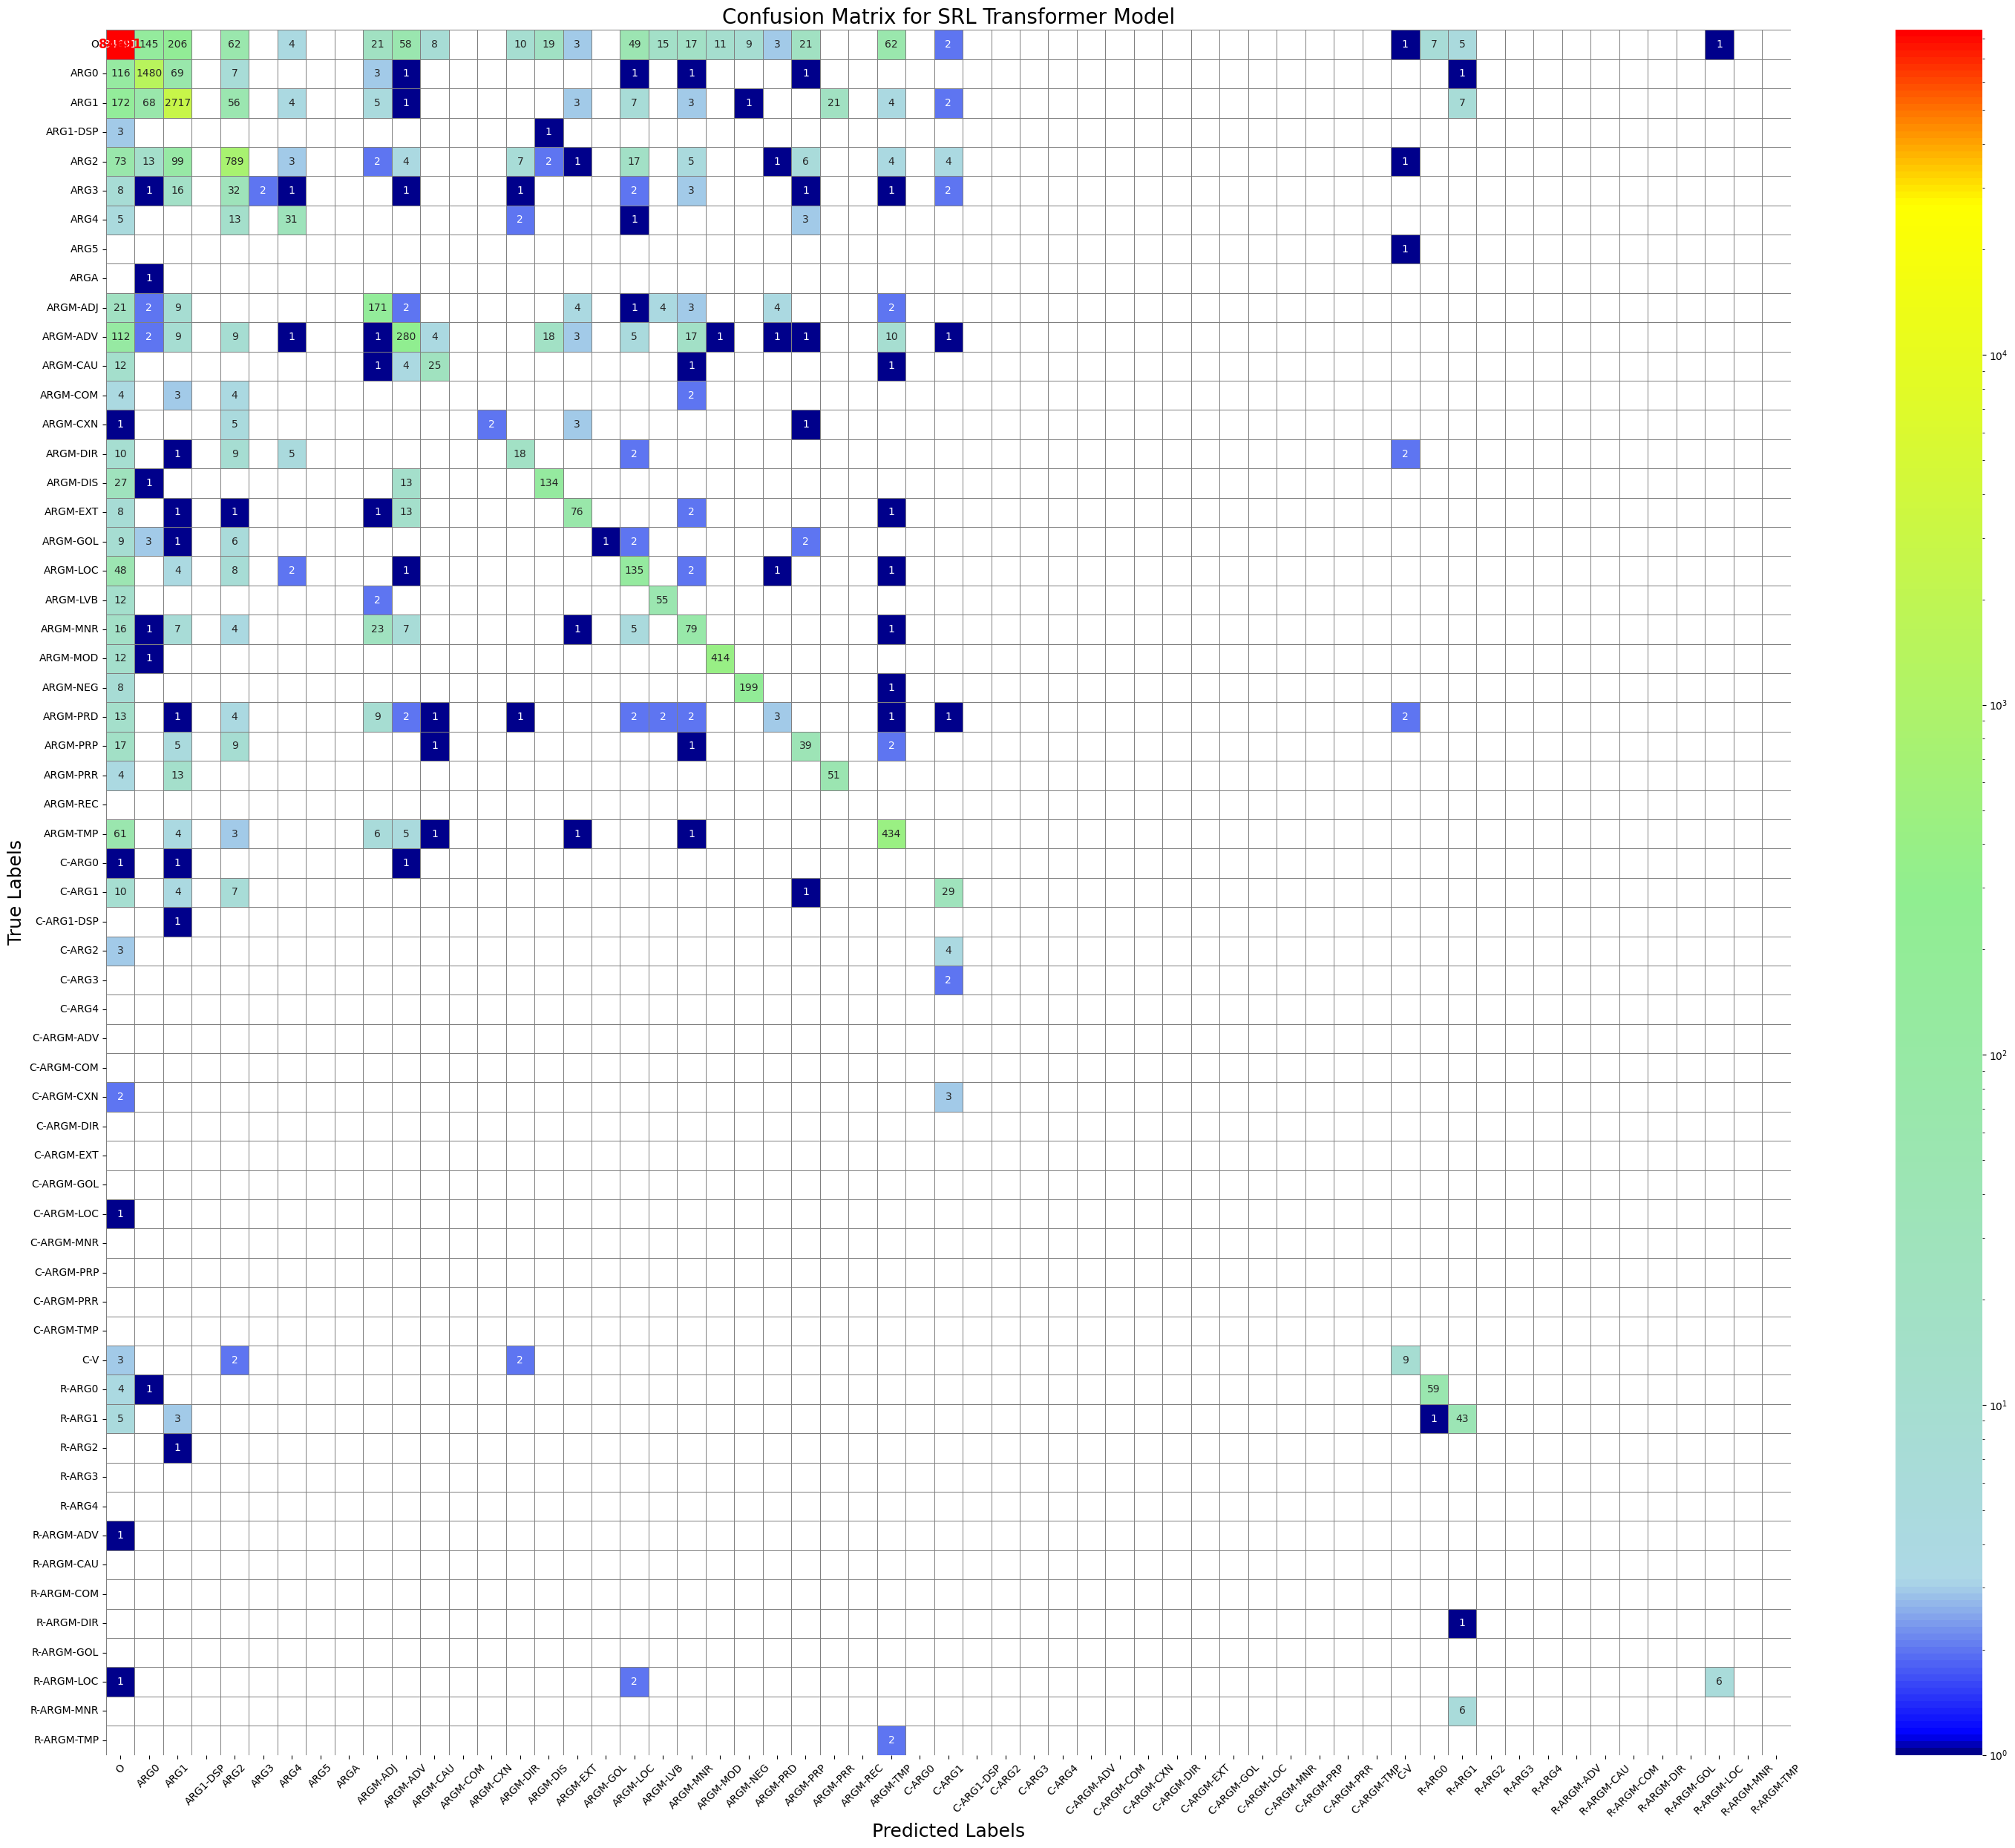

In [109]:
categories = label_list.copy() ## Get categories for confusion matrix
if 'O' in categories: #put O first
    categories.remove('O')
    categories = ['O'] + sorted(categories)
conf_matrix = confusion_matrix(true_labels, true_predictions, labels=categories)

colors = [(0.0, "darkblue"), (0.01, "blue"), (0.1, "lightblue"), 
          (0.5, "lightgreen"), (0.9, "yellow"), (1.0, "red")]
custom_cmap = LinearSegmentedColormap.from_list("sharp_start", colors)

plt.figure(figsize=(30, 25))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_cmap, 
            xticklabels=categories, yticklabels=categories, 
            norm=LogNorm(vmin=1, vmax=conf_matrix.max()), 
            linewidths=0.5, linecolor='grey')

for i in range(len(categories)):
    for j in range(len(categories)):
        if conf_matrix[i, j] > conf_matrix.max() * 0.8:
            plt.text(j + 0.5, i + 0.5, conf_matrix[i, j], 
                    color='red', ha='center', va='center', 
                    fontsize=12, fontweight='bold')

plt.xlabel('Predicted Labels', fontsize=18)
plt.ylabel('True Labels', fontsize=18)
plt.title('Confusion Matrix for SRL Transformer Model', fontsize=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Classification report

In [110]:
print("Classification Report:")
classification_report_str = classification_report(true_labels, true_predictions)
print(classification_report_str)

Classification Report:
              precision    recall  f1-score   support

        ARG0       0.86      0.88      0.87      1680
        ARG1       0.86      0.88      0.87      3071
    ARG1-DSP       0.00      0.00      0.00         4
        ARG2       0.77      0.77      0.77      1031
        ARG3       1.00      0.03      0.05        71
        ARG4       0.61      0.56      0.58        55
        ARG5       0.00      0.00      0.00         1
        ARGA       0.00      0.00      0.00         1
    ARGM-ADJ       0.70      0.77      0.73       223
    ARGM-ADV       0.71      0.59      0.65       475
    ARGM-CAU       0.62      0.57      0.60        44
    ARGM-COM       0.00      0.00      0.00        13
    ARGM-CXN       1.00      0.17      0.29        12
    ARGM-DIR       0.44      0.38      0.41        47
    ARGM-DIS       0.77      0.77      0.77       175
    ARGM-EXT       0.80      0.74      0.77       103
    ARGM-GOL       1.00      0.04      0.08        24
    

/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Save output of model predictions

In [114]:
output_df = pd.DataFrame({
    'Token': true_tokens,
    'Gold Label': true_labels,
    'Predicted Label': true_predictions
})
output_df.to_csv('test_predictions.csv', index=False)

## Standalone function

We condense the steps from above into a standalone function.

In [112]:
def predict_srl_tags(tokens,predicate_indicators, trainer, label_list):
    """
    Make SRL predictions for a sentence with potentially multiple predicates.
    """
    predicate_positions = [i for i, indicator in enumerate(predicate_indicators) if indicator == 1] # Find all predicate positions
    
    if not predicate_positions:
        return []
    # Create a mini dataset with all predicates at once
    examples = {
        "id": list(range(len(predicate_positions))),
        "tokens": [tokens] * len(predicate_positions),
        "predicate_pos": predicate_positions,
        "SRL_tags": [[0] * len(tokens)] * len(predicate_positions)  # Placeholder tags
    }
    mini_dataset = Dataset.from_dict(examples)
    
    tokenized_examples = mini_dataset.map( # Apply tokenization to the entire batch
        tokenize_and_align_labels,
        batched=True,
    )
    predictions, _, _ = trainer.predict(tokenized_examples)
    predictions = np.argmax(predictions, axis=2)
    
    all_predictions = []
    
    for i, predicate_pos in enumerate(predicate_positions):
        pred = predictions[i]
        
        tokens_before = tokens[:predicate_pos+1]
        tokens_after = tokens[predicate_pos+1:]
        
        word_ids = make_word_ids(tokens_before, tokens_after, predicate_pos)
        predicted_tags = [None] * len(tokens)
        for token_idx, word_idx in enumerate(word_ids):
            if word_idx is None: # Skip special tokens 
                continue
            else:
                predicted_tags[word_idx] = label_list[pred[token_idx]]
        
        for j in range(len(predicted_tags)): # Fill in any missing predictions with 'O'
            if predicted_tags[j] is None:
                predicted_tags[j] = 'O'
        
        predicted_tags[predicate_pos] = 'V' # Mark the predicate position with 'V'
        
        all_predictions.append(predicted_tags)
    
    return all_predictions


In [113]:
tokenized_sentence = ["John", "bought", "a", "car", "and", "drove", "it", "to", "work", "."]
predicate_indicators = [0, 1, 0, 0, 0, 1, 0, 0, 0, 0]

print(predict_srl_tags(tokenized_sentence, predicate_indicators, trainer, label_list))

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARGM-PRP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/nvme0n1p1/elective/advanced-nlp/ass2/env/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/nvme0n1p1/

[['ARG0', 'V', 'O', 'ARG1', 'O', 'O', 'O', 'O', 'O', 'O'], ['ARG0', 'O', 'O', 'O', 'O', 'V', 'ARG1', 'O', 'ARGM-PRP', 'O']]
